In [10]:
import pandas as pd
import numpy as np
# from pycirclize import Circos
# from pycirclize.utils import ColorCycler
import matplotlib.pyplot as plt
import numpy as np


In [11]:
def ligate_sequence(seq, add_len):
    seq = str(seq)
    seqlen = len(seq)
    if seqlen >= add_len:
        extra = seq[:add_len]
    else:
        repeat_times = add_len // seqlen
        remainder = add_len % seqlen
        extra = seq * repeat_times + seq[:remainder]
    return seq + extra

In [12]:

# 加载circRNA序列
csv_path = "/lulabdata3/huangkeyun/zhangys/RNA_locator/ML_python_scripts/reference_preprocessing/circRNA/output_with_sequences.csv"
df = pd.read_csv(csv_path, sep = '\t')
add_len = 4 
df["Sequence"] = df["Sequence"].apply(
    lambda x: ligate_sequence(x, add_len)
)
# 提取序列列
sequences = df["Sequence"].dropna()

# 指定的20个kmer
ev_kmers = ['TAG', 'TAGA', 'ATTT', 'GAGAG']
cyto_kmers = ['CGGA', 'TCAAG', 'CACCA', 'TGACC', 'TCTAC', 'GTCC', 'GTC', 'CCG', 'CGA',
       'TACG', 'AGTCC', 'CCAAG', 'CGGAA', 'CTCAA', 'CGAC', 'ACC']
all_kmers = cyto_kmers + ev_kmers

# 初始化参数
num_bins = 100
kmer_bin_counts = {kmer: np.zeros(num_bins) for kmer in all_kmers}

In [13]:
# 统计每个kmer在所有序列中每个bin内的出现次数
for seq in sequences:
    seq_len = len(seq)
    extended_seq = seq + seq[:max(map(len, all_kmers))]  # 环形拼接
    for kmer in all_kmers:
        k = len(kmer)
        positions = [i for i in range(seq_len) if extended_seq[i:i+k] == kmer]
        for pos in positions:
            bin_idx = int((pos % seq_len) / seq_len * num_bins)
            kmer_bin_counts[kmer][bin_idx] += 1

In [14]:
# 归一化为平均每个序列上的频率
for kmer in all_kmers:
    kmer_bin_counts[kmer] = kmer_bin_counts[kmer] / len(sequences)
# 准备数据用于堆叠柱状图绘制
bin_matrix = np.array([kmer_bin_counts[kmer] for kmer in all_kmers])  # shape: (20, 100)
x = np.arange(num_bins)
stack_bottom = np.zeros(num_bins)

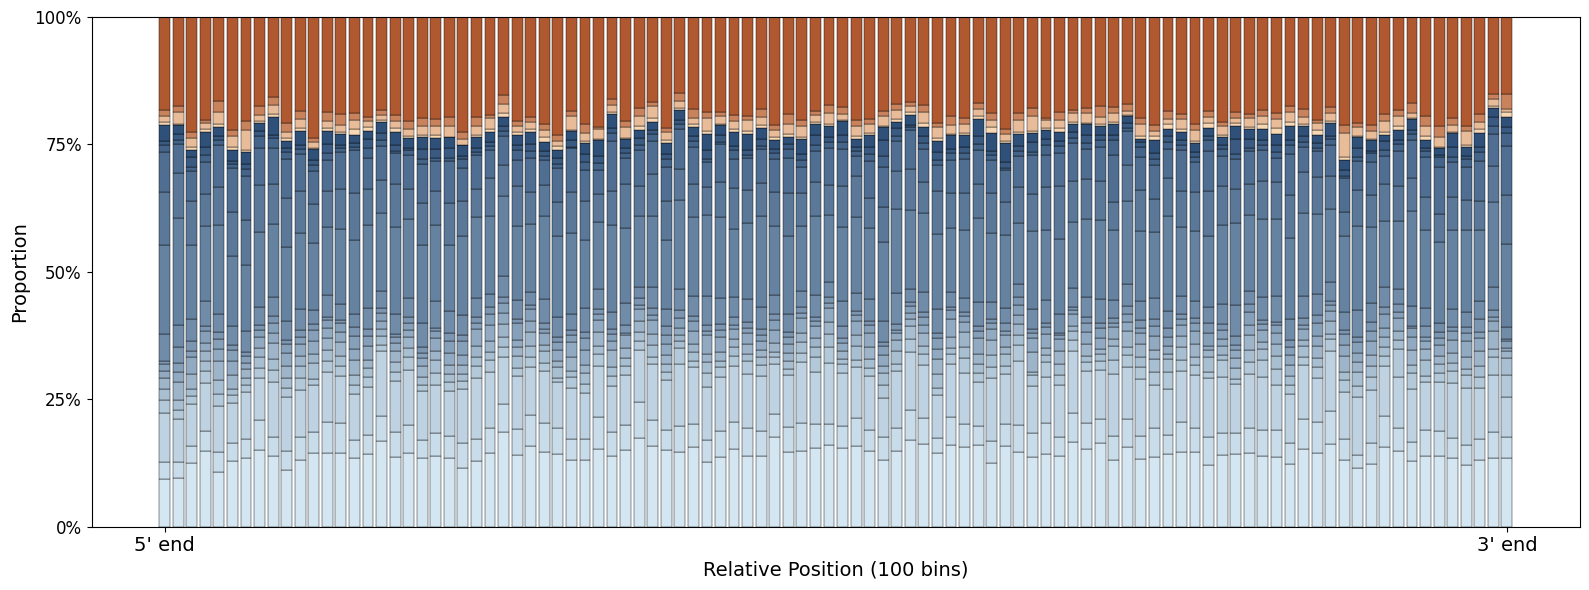

In [6]:
all_kmers = ev_kmers + cyto_kmers

num_bins = 100
kmer_bin_counts = {kmer: np.zeros(num_bins) for kmer in all_kmers}

for seq in sequences:
    seq_len = len(seq)
    extended_seq = seq + seq[:max(map(len, all_kmers))]
    for kmer in all_kmers:
        k = len(kmer)
        positions = [i for i in range(seq_len) if extended_seq[i:i+k] == kmer]
        for pos in positions:
            bin_idx = int((pos % seq_len) / seq_len * num_bins)
            kmer_bin_counts[kmer][bin_idx] += 1

for kmer in all_kmers:
    kmer_bin_counts[kmer] /= len(sequences)

bin_matrix = np.array([kmer_bin_counts[kmer] for kmer in all_kmers])
bin_sums = bin_matrix.sum(axis=0, keepdims=True)
bin_sums[bin_sums == 0] = 1
bin_matrix = bin_matrix / bin_sums

# ==== 普通堆积柱状图 ====
x = np.arange(num_bins)

cool_colors = [
    '#D4E6F1', '#C9DCE9', '#BED2E1', '#B3C8D9', '#A8BED1', '#9DB4C9',
    '#92AAC1', '#87A0B9', '#7C96B1', '#718CA9', '#6682A1', '#5B7899',
    '#506E91', '#456489', '#3A5A81', '#2F5079'
]
# 暖色调（4种，对应ev_kmers）
warm_colors = [
    '#F8D7B4', '#E8BB99', '#C8835D', '#B05930'
]

colors = cool_colors + warm_colors

bottom = np.zeros(num_bins)
plt.figure(figsize=(16, 6))

for i in range(len(all_kmers)):
    plt.bar(x, bin_matrix[i], bottom=bottom, color=colors[i], edgecolor='black', linewidth=0.3)
    bottom += bin_matrix[i]

# y轴百分比
plt.ylabel("Proportion", fontsize=14)
plt.xlabel("Relative Position (100 bins)", fontsize=14)
plt.ylim(0, 1)
plt.yticks(np.linspace(0, 1, 5), [f"{int(p*100)}%" for p in np.linspace(0, 1, 5)], fontsize=12)

# 自定义 x 轴刻度（在 0 和 99 位置标 5' 和 3'）
plt.xticks([0, num_bins - 1], ["5' end", "3' end"], fontsize=14)

plt.tight_layout()
plt.show()


<Figure size 200x600 with 0 Axes>

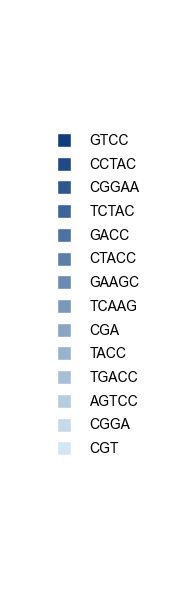

In [14]:
import matplotlib.pyplot as plt

# ===== 输入数据 =====
ev_kmers = ['CCAAA', 'GCG', 'AAGAC', 'CTTC', 'AACC', 'ATGGT', 'GCACT', 'GTGC', 'TGAG', 'GAGAC', 'CGTA']
# 暖色调（6种，对应ev_kmers）
warm_colors = [
    '#F8D7B4', '#F0C9A8', '#E8BB99', '#D89F7B', '#C8835D', '#B05930'
]

# 冷色调（14种，对应cyto_kmers）
cool_colors = [
    '#D4E6F1', '#C5D9E8', '#B6CCDF', '#A7BFD6', '#98B2CD',
    '#89A5C4', '#7A98BB', '#6B8BB2', '#5C7EA9', '#4D71A0',
    '#3E6497', '#2F578E', '#204A85', '#113D7C'
]

# ===== 公共绘图函数 =====
def plot_kmer_legend(kmers, colors, filename, labelspacing=0.6, markersize=10, figsize=(2, 6)):
    """
    绘制 k-mer 与颜色对应的图例，并保存为透明背景图片
    """
    plt.figure(figsize=figsize)
    plt.rcParams['font.family'] = 'Arial'
    fig, ax = plt.subplots(figsize=figsize)

    handles = []
    for kmer, color in zip(kmers, colors):
        patch = plt.Line2D(
            [0], [0], marker='s', color='w', label=kmer,
            markerfacecolor=color, markersize=markersize
        )
        handles.append(patch)

    legend = ax.legend(
        handles=handles,
        labels=kmers,
        loc='center',
        ncol=1,
        frameon=False,
        labelspacing=labelspacing  # 控制行间距
    )
    ax.axis('off')

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

plot_kmer_legend(cyto_kmers[::-1], cool_colors[::-1], "legend_ev.png", labelspacing=0.7)

<Figure size 200x600 with 0 Axes>

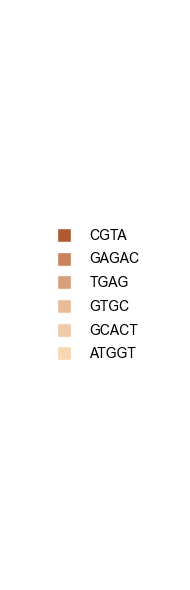

In [15]:
plot_kmer_legend(ev_kmers[::-1], warm_colors[::-1], "legend_ev.png", labelspacing=0.7)

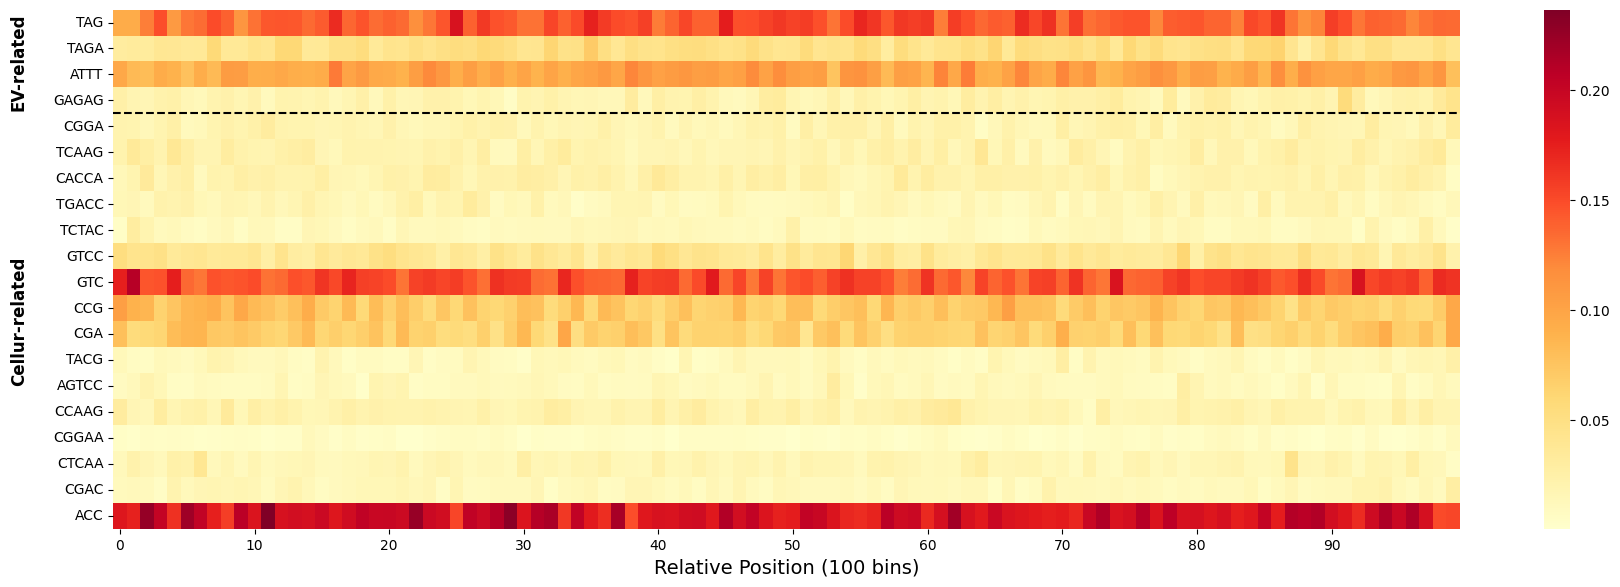

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 组别信息
all_kmers = ev_kmers + cyto_kmers

# 绘制热图
plt.figure(figsize=(18, 6))
ax = sns.heatmap(
    bin_matrix,
    cmap="YlOrRd",
    xticklabels=10,
    yticklabels=all_kmers,
    cbar_kws={'label': ''}
)

# 添加分组分隔线（EV 组在前 6 行，Cyto 组在后 14 行）
ev_count = len(ev_kmers)
ax.hlines(ev_count, *ax.get_xlim(), colors='black', linestyles='dashed', linewidth=1.5)

# 添加组别标签
plt.text(
    -7, ev_count / 2, "EV-related", rotation=90, va='center', ha='center', fontsize=12, fontweight='bold'
)
plt.text(
    -7, ev_count + (len(cyto_kmers) / 2), "Cellur-related", rotation=90, va='center', ha='center', fontsize=12, fontweight='bold'
)

# plt.title("K-mer Positional Enrichment Heatmap Across circRNA", fontsize=14, fontweight='bold')
plt.xlabel("Relative Position (100 bins)", fontsize=14)
# plt.ylabel("K-mer")
plt.tight_layout()
plt.show()


In [11]:
# 环形图构建
circos1 = Circos(sectors={"circRNA": num_bins})
sector = circos1.sectors[0]
track = sector.add_track((40, 100))
track.axis()


warm_colors = [
    '#F8D7B4', '#F0C9A8', '#E8BB99', '#E0AD8A', '#D89F7B', '#D0916C',
    '#C8835D', '#C0754E', '#B8673F', '#B05930', '#A84B21'
]
cool_colors = [
    '#D4E6F1', '#C5D9E8', '#B6CCDF', '#A7BFD6', '#98B2CD',
    '#89A5C4', '#7A98BB', '#6B8BB2', '#5C7EA9'
]
colors = warm_colors + cool_colors

# 重置堆积底部高度
stack_bottom = np.zeros(num_bins)

for i in range(len(all_kmers)):
    track.bar(
        x,
        bin_matrix[i],
        bottom=stack_bottom,
        width=1.0,
        color=colors[i],
        ec="black",
        lw=0.2
    )
    stack_bottom += bin_matrix[i]

# 输出图形
fig = circos1.plotfig()
plt.show()


NameError: name 'Circos' is not defined

In [ ]:
plot_kmer_legend(cyto_kmers, cool_colors, "legend_ev.png", labelspacing=0.7)

In [ ]:
plot_kmer_legend(ev_kmers, warm_colors, "legend_ev.png", labelspacing=0.7)

In [ ]:
plot_kmer_legend(ev_kmers, warm_colors, "legend_ev.png", labelspacing=0.7)

In [ ]:
warm_colors = [
    '#F8D7B4',  # 浅杏色 (Light Apricot)
    '#F0C9A8',  # 沙色 (Sand)
    '#E8BB99',  # 陶土色 (Terracotta)
    '#E0AD8A',  # 灰粉色 (Dusty Pink)
    '#D89F7B',  # 黏土色 (Clay)
    '#D0916C',  # 肉桂色 (Cinnamon)
    '#C8835D',  # 赤陶色 (Red Clay)
    '#C0754E',  # 锈色 (Rust)
    '#B8673F',  # 赭石色 (Ochre)
    '#B05930',  # 深陶色 (Deep Terracotta)
    '#A84B21'   # 砖红色 (Brick Red)
]

cool_colors = [
    '#D4E6F1',  # 雾蓝色 (Mist Blue)
    '#C5D9E8',  # 灰蓝色 (Grayish Blue)
    '#B6CCDF',  # 钢蓝色 (Steel Blue)
    '#A7BFD6',  # 灰蓝 (Slate Blue)
    '#98B2CD',  # 冷蓝色 (Cool Blue)
    '#89A5C4',  # 蓝灰色 (Blue Gray)
    '#7A98BB',  # 灰蓝 (Dusty Blue)
    '#6B8BB2',  # 深灰蓝 (Deep Gray Blue)
    '#5C7EA9'   # 暗蓝色 (Dark Muted Blue)
]

import matplotlib.pyplot as plt
import numpy as np

def plot_colors(colors, title):
    fig, ax = plt.subplots(figsize=(10, 2))
    for i, color in enumerate(colors):
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))
    ax.set_xlim(0, len(colors))
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title, pad=20)
    plt.show()

plot_colors(warm_colors, "Warm Colors (Low Saturation)")
plot_colors(cool_colors, "Cool Colors (Low Saturation)")

In [ ]:
import pandas as pd
import numpy as np
from pycirclize import Circos
import matplotlib.pyplot as plt

# 加载circRNA序列
csv_path = "/BioII/lulab_b/huangkeyun/zhangys/RNA_locator/archived/circExor_archived_2025_5/sample_preprocessing/circRNA/output_with_sequences.csv"
df = pd.read_csv(csv_path, sep='\t')
df = df[df['Sequence'] != 'Sequence_not_found']
sequences = df["Sequence"].dropna()

# 20个kmer
ev_kmers = ['CCAAA', 'GCG', 'AAGAC', 'CTTC', 'AACC', 'ATGGT', 'GCACT', 'GTGC', 'TGAG', 'GAGAC', 'CGTA']
cyto_kmers = ['AGT', 'TCTAG', 'TACAG', 'CGCA', 'ATAA', 'GTGA', 'GACC', 'TGGC', 'AACTT']
all_kmers = ev_kmers + cyto_kmers

# 初始化统计矩阵
num_bins = 100
kmer_bin_counts = {kmer: np.zeros(num_bins) for kmer in all_kmers}

# 统计每个bin的kmer频率
for seq in sequences:
    seq_len = len(seq)
    extended_seq = seq + seq[:max(map(len, all_kmers))]  # 环形拼接
    for kmer in all_kmers:
        k = len(kmer)
        positions = [i for i in range(seq_len) if extended_seq[i:i+k] == kmer]
        for pos in positions:
            bin_idx = int((pos % seq_len) / seq_len * num_bins)
            kmer_bin_counts[kmer][bin_idx] += 1

# 归一化为平均频率
for kmer in all_kmers:
    kmer_bin_counts[kmer] /= len(sequences)

# 构建矩阵 (20, num_bins)
bin_matrix = np.array([kmer_bin_counts[kmer] for kmer in all_kmers])

# ===== 百分比堆积归一化 =====
bin_sums = bin_matrix.sum(axis=0, keepdims=True)
# 避免除以0
bin_sums[bin_sums == 0] = 1
bin_matrix = bin_matrix / bin_sums

# ===== 绘制环形图 =====
circos1 = Circos(sectors={"circRNA": num_bins})
sector = circos1.sectors[0]
track = sector.add_track((40, 100))  # 半径范围

# 颜色
warm_colors = [
    '#F8D7B4', '#F0C9A8', '#E8BB99', '#E0AD8A', '#D89F7B', '#D0916C',
    '#C8835D', '#C0754E', '#B8673F', '#B05930', '#A84B21'
]
cool_colors = [
    '#D4E6F1', '#C5D9E8', '#B6CCDF', '#A7BFD6', '#98B2CD',
    '#89A5C4', '#7A98BB', '#6B8BB2', '#5C7EA9'
]
colors = warm_colors + cool_colors

# 绘制堆积柱状
x = np.arange(num_bins)
for j in range(num_bins):
    bottom = 0.0
    xj = np.array([x[j]])
    for i in range(len(all_kmers)):
        hj = np.array([bin_matrix[i, j]])
        track.bar(
            xj,
            hj,
            bottom=np.array([bottom]),
            width=1.0,
            color=colors[i],
            ec="black",
            lw=0.3,
            antialiased=True,
            zorder=i
        )
        bottom += hj[0]

# ===== 添加百分比纵坐标刻度 =====
# 刻度值 0%, 25%, 50%, 75%, 100%
percent_ticks = np.linspace(0, 1, 5)
track.axis(
    # rlim=(0, 1),
    # rticks=percent_ticks,
    # show=True,
    # tick_labels=[f"{int(p*100)}%" for p in percent_ticks],
    lw=0.5,
    # label_size=8
)

# 输出图形
fig = circos1.plotfig()
plt.show()
